In [7]:
import os
import re
from cv2 import exp
import numpy as np
import matplotlib.pyplot as plt
from ArUCo_Markers_Pose import pose_data, pose_estimation
from Utilities.Helpers import toTime
import time
import json
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from matplotlib.animation import FuncAnimation
from experiments import get_all_input
from datetime import datetime, timedelta
import pandas as pd
import plotly.express as px
import heapq
from DataCleaner import clean
import webbrowser
import math
from collections import defaultdict

from scipy.signal import butter, filtfilt
from scipy import integrate
import sys
!{sys.executable} -m pip install dash

import dash
from dash import dcc, html, Input, Output
import plotly.colors as pc
from data_analysis import data_analysis, compute_speed, merge_parameter_data

print(os.getcwd())
debug = True
fps = 30


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
plot_data = None
# path = './exploreData/Snake/'
# for folder in os.listdir(path):
#     print(f'folder: {folder}')
#     filepath = f'{path}/{folder}'
#     files = os.listdir(filepath)
#     # Extract the poses from the video
#     if 'marker_pose.log' not in files:
#         video = None
#         for file in files:
#             if os.path.splitext(file)[1].lower() == '.mp4':
#                 video = f'/{file}'
#         print("analyzing the video...")
#         aruco_pose = pose_estimation.Aruco_pose(filepath+video)
#         aruco_pose.pose_estimation()

# print('Cleaning ...')
# clean(path, True)

print('Processing the data...')
path = './cleanData/Snake/'
plot_data = data_analysis(path)

plot_data['Phase_difference'] = plot_data['Phase_difference'] * 180 / np.pi # radians to degrees

with open(f'cleanData/Snake/plot data.log', 'w') as f:
    json.dump(plot_data.to_dict(orient='records'), f)

Processing the data...
folder: 0-179
Getting the edmo's positions...
nb of frames: 54097
Matching the edmo's movement with the input data...
Skipped input: (1, (20, 20), (0, 0), [0.0, 5.585053606381854]), start ends: [[61, 4426], []]
inputs skipped : 1
Computing the edmo's speed ...
avg x displacement: -2.4723396411004577e-05, max : [0.04944045321467949, 0.04906901539329278, 0.04792976739564253], min : [-0.04898209815323351, -0.04608556429844923, -0.04353107755866337]
avg y displacement: 2.685424449595349e-05, max : [0.024473105492959668, 0.023589671043192317, 0.023032685226235916], min : [-0.024703853815346788, -0.024082869345387392, -0.023675241784223977]
avg z displacement: 3.846602962278886e-06, max : [0.08997613621019995, 0.08450232563296245, 0.08418574641019849], min : [-0.08189224632749781, -0.07372520341652111, -0.07319742526031092]
folder: 1080-1259
Getting the edmo's positions...
nb of frames: 54095
Matching the edmo's movement with the input data...
Skipped input: (1, (40, 4

In [ ]:
    
# Retrieve the data from the json file
with open('cleanData/Snake/plot data.log', 'r') as f:
    data = json.load(f)

# # Convert to DataFrame
plot_data = pd.DataFrame.from_records(data)

print(plot_data)

      Amp_motor_1  Amp_motor_2  Offset_motor_1  Offset_motor_2  \
0              20           20               0               0   
1              20           20               0               0   
2              20           20               0               0   
3              20           20               0               0   
4              20           20               0               0   
...           ...          ...             ...             ...   
2919           40           40              60             150   
2920           40           40              60             150   
2921           40           40              60             150   
2922           40           40              60             150   
2923           40           40              60             150   

      Phase_difference   x speed   y speed   z speed  xyz speed  xy speed  \
0                  0.0 -0.052737 -0.004050  0.011682   0.054167  0.052892   
1                 40.0 -0.000689  0.010257  0.032821 

# <ins> Parallel Plot </ins>

In [ ]:
def parallel_coord(plot_data, color_scale, speed_type):
    tooltip = plot_data.apply(
        lambda row: f"Exp: {row['exp nb']}, Amp1: {row['Amp_motor_1']:.2f}, Amp2: {row['Amp_motor_2']:.2f}, "
                    f"Offset1: {row['Offset_motor_1']:.2f}, Offset2: {row['Offset_motor_2']:.2f}, "
                    f"Phase: {row['Phase_difference']:.1f}, Speed: {row[speed_type]:.2f}",
        axis=1
    )
    
    fig = go.Figure(data=go.Parcoords(
        line=dict(
            color=plot_data[speed_type],  # Color by 'Speed'
            colorscale=color_scale,  
            showscale=True,  
            cmin=plot_data[speed_type].min(),  
            cmax=plot_data[speed_type].max()
        ),
        dimensions=[
            dict(
                label='experiment number', 
                values=plot_data['exp nb'],
                range=[plot_data['exp nb'].min(), plot_data['exp nb'].max()]
            ),
            dict(
                label='Amp_motor_1', 
                values=plot_data['Amp_motor_1'],
                range=[plot_data['Amp_motor_1'].min(), plot_data['Amp_motor_1'].max()]
            ),
            dict(
                label='Amp_motor_2', 
                values=plot_data['Amp_motor_2'],
                range=[plot_data['Amp_motor_2'].min(), plot_data['Amp_motor_2'].max()]
            ),
            dict(
                label='Offset_motor_1', 
                values=plot_data['Offset_motor_1'],
                range=[plot_data['Offset_motor_1'].min(), plot_data['Offset_motor_1'].max()]  # Set the range based on data
            ),
            dict(
                label='Offset_motor_2', 
                values=plot_data['Offset_motor_2'],
                range=[plot_data['Offset_motor_2'].min(), plot_data['Offset_motor_2'].max()]
            ),
            dict(
                label='Phase_difference', 
                values=plot_data['Phase_difference'],
                range=[plot_data['Phase_difference'].min(), plot_data['Phase_difference'].max()]
            ),
            dict(
                label=speed_type, 
                values=plot_data[speed_type],
                range=[plot_data[speed_type].min(), plot_data[speed_type].max()]
            )
        ],
    ))
    

    # Update layout for better presentation
    fig.update_layout(
        title="Interactive Parallel Coordinates Plot",
        title_x=0.5,  # Center the title
        width=1300,
        height=800,
        showlegend=False,  # Hide the legend
        hovermode="closest",  # Show hover data when hovering closest to a line
        dragmode='zoom',  # Enable zooming and panning
        
    )

    fig.write_html('parallel_plot.html')
    webbrowser.open('parallel_plot.html')

color_scale = 'jet'
speed_type = ['x speed', 'y speed', 'z speed', 'xyz speed',  'xy speed', \
              'x frame speed', 'y frame speed', 'z frame speed', 'xyz frame speed', 'xy frame speed', 'exp nb', 'nb frames']
parallel_coord(plot_data, color_scale, speed_type[11])

### 3D Parallel plot


In [ ]:

def parallel_3d_plot(data: dict[str, int|float], speed_type:str):
    plot_data = pd.DataFrame(data)
    plot_data['Index'] = plot_data.index
    min_speed = plot_data[speed_type].min()
    max_speed = plot_data[speed_type].max()

    # Normalize data for the plot
    parameters = [
        'Amp_motor_1',
        'Amp_motor_2',
        'Offset_motor_1',
        'Offset_motor_2',
        'Phase_difference'
    ]

    # Normalize data for consistent plotting
    norm_data = plot_data.copy()
    for dim in parameters:
        match dim:
            case 'Amp_motor_1' | 'Amp_motor_2':
                norm_data[dim] = plot_data[dim] / 90
            case 'Offset_motor_1' | 'Offset_motor_2':
                norm_data[dim] = plot_data[dim] / 180
            case 'Phase_difference':
                norm_data[dim] = plot_data[dim] / 360
            case speed_type:
                norm_data[dim] = plot_data[dim] 
                
    norm_data[speed_type] = norm_data[speed_type].fillna(np.nan).infer_objects(copy=False)

    # Initialize the Dash app
    app = dash.Dash(__name__)
    # app = JupyterDash(__name__)


    # Define filter ranges for each dimension
    filter_param = {
        'Amp_motor_1': [0, 90],
        'Amp_motor_2': [0, 90],
        'Offset_motor_1': [0, 180],
        'Offset_motor_2': [0, 180],
        'Phase_difference': [0, 360],
        speed_type: [0, max_speed]  
    }

    # Layout of the app
    app.layout = html.Div([
    html.H1("Interactive 3D Parallel Coordinates Plot", style={'textAlign': 'center'}),
    dcc.Graph(id='parallel-3d-plot'),
    
    # Save button
    html.Button("Save Plot as HTML", id='save-button', n_clicks=0),
    
    # Message area
    html.Div(id='save-message', style={'padding': '10px'}),
    
    html.Div(
        [
            html.Div([ 
                html.Label(f"Filter {param}:"),
                dcc.RangeSlider(
                    id=f'{param}-filter',
                    min=value_range[0],
                    max=math.ceil(value_range[1]),
                    step=1 if dim != speed_type else 0.1,
                    marks={value_range[0]: f'{value_range[0]}', 
                           (math.ceil(value_range[1]) + value_range[0]) / 2: f'{(value_range[0] + math.ceil(value_range[1])) / 2}', 
                           int(value_range[1]): f'{math.ceil(value_range[1])}'},
                    value=[value_range[0], math.ceil(value_range[1])]
                ),
                html.Div(id=f'{param}-value', style={'padding-left': '10px'})
            ]) for param, value_range in filter_param.items()
        ],  
        style={'display': 'flex', 'flexDirection': 'column', 'gap': '20px'}
    )
    ])


    # Callback to update the 3D plot based on filter ranges
    @app.callback(
        Output('parallel-3d-plot', 'figure'),
        [Input(f'{param}-filter', 'value') for param in filter_param]
    )
    def update_plot(*filters):
        # Apply filters to the normalized data
        filtered_data = norm_data.copy()
        print(filters)
        for i, (dim, filter_range) in enumerate(filter_param.items()):
            min_val, max_val = filters[i]
            if dim == speed_type:
                filtered_data = filtered_data[
                    (filtered_data[dim] >= (min_val)) & 
                    (filtered_data[dim] <= (max_val))
                ]
            else:
                filtered_data = filtered_data[
                    (filtered_data[dim] >= (min_val / (filter_range[1] - filter_range[0]))) & 
                    (filtered_data[dim] <= (max_val / (filter_range[1] - filter_range[0])))
                ]

        # Generate 3D lines for the plot
        lines = []
        for _, row in filtered_data.iterrows():
            x_dims = list(range(len(parameters)))  # parameters (0, 1, 2, ...)
            y_time = [int(row["Index"])] * len(parameters)  # Same time for a single data point
            z_values = row[parameters].values  # Normalized values of the parameters

            # Prepare the hover text showing original values and index
            hover_text = f"Index: {int(row['Index'])}<br>" + f"Speed: {row[speed_type]:.2f}<br>" + "<br>".join(
                [f"{dim}: {plot_data[dim].iloc[int(row['Index'])]:.2f}" for dim in parameters]
            )

            color = 'black'
            if not pd.isna(row[speed_type]):
                color = pc.sample_colorscale('jet', [row[speed_type]/(max_speed)])[0]  # Get the color from the jet scale

            # Add each line as a separate trace
            lines.append(go.Scatter3d(
                x=x_dims,
                y=y_time,
                z=z_values,
                mode='lines',
                line=dict(
                    color=color,  # Color by 'Speed'
                    colorscale='jet',
                    cmin=min_speed,  # Minimum of the speed type
                    cmax=max_speed,  # Maximum of the speed type
                    colorbar=dict(
                    title=speed_type,  # Title for the color bar
                    thickness=15,  # Thickness of the color bar
                    len=1,  # Length of the color bar as a fraction of plot height
                    x=0.92,  # Position of the color bar (move it to the right)
                ),
                    width=2
                ),
                marker=dict(size=2),
                text=hover_text,  # Add the hover text here
                hoverinfo='text',  # Show only the text when hovering
                name=f"Index {int(row['Index'])}"  # Set the trace name as the index
            ))


        # Update layout
        fig = go.Figure(data=lines)
        fig.update_layout(
            scene=dict(
                xaxis=dict(
                    title="Parameters",
                    tickvals=list(range(len(parameters))),
                    ticktext=parameters,
                    range=[-1, len(parameters)]
                ),
                yaxis=dict(title="Time", range=[-1, len(plot_data['Index'])]),
                zaxis=dict(title="Normalized Values", range=[-0.1, 1.1]),
            ),
            width=1300,
            height=800
        )

        return fig

    @app.callback(
        Output('save-message', 'children'),
        [Input('save-button', 'n_clicks')],
        [Input('parallel-3d-plot', 'figure')]
    )
    def save_plot(n_clicks, figure):
        if n_clicks > 0:
            # Save the figure as an HTML file
            fig = go.Figure(figure)
            fig.write_html("plot.html")  # Save as HTML
            return "Plot saved as 'plot.html'"
        return ""
    
    # Callback to update the current value display for sliders
    @app.callback(
        [Output(f'{dim}-value', 'children') for dim in filter_param],
        [Input(f'{dim}-filter', 'value') for dim in filter_param]
    )
    def update_slider_value(*values):
        return [f"Current value: {value[0]} to {value[1]}" for value in values]

    app.run_server(debug=True, use_reloader=False)
    # http://127.0.0.1:8050/

with open('cleanData/Snake/plot data.log', 'r') as f:
    data = json.load(f)

# Convert to DataFrame
plot_data = pd.DataFrame.from_records(data)

print(plot_data)
speed_type = ['x speed', 'y speed', 'z speed', 'xyz speed',  'xy speed', \
            'x abs speed', 'y abs speed', 'z abs speed', 'xyz abs speed', 'xy abs speed']
parallel_3d_plot(plot_data[:40], speed_type[4])


2024.09.17
Kumoko
2024.09.19
Cadence
all inputs:[0]
input 0
freq 0.3
all inputs:[0]
input 0
amp 0
all inputs:[0, 1]
input 0
input 1
freq 0.05
all inputs:[0, 1]
input 0
input 1
amp 1
Kiwi
all inputs:[]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:237                                                                                  │
│                                                                                                  │
│   234 │   │   │   │   │   │   times.append(c_timedelta)                                          │
│   235 │   │   │   │   │   │   indexes[i] += 1                                                    │
│   236 │   │   │   │   │   │   break                                                              │
│ ❱ 237 │   │   │   │   min_index = np.argmin(times)                                               │
│   238 │   │   │   │   parameters = input_data[min_index][indexes[min_index]].split(': ')[1]      │
│   239 │   │   │   │   print(parameters)                                                          │
│   240 │   │   │   │   break                                                                      │
│                                                                                                  │
│ c:\Users\Ye\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py │
│ :1457 in argmin                                                                                  │
│                                                                                                  │
│   1454 │   (2, 1, 4)                                                                             │
│   1455 │   """                                                                                   │
│   1456 │   kwds = {'keepdims': keepdims} if keepdims is not np._NoValue else {}                  │
│ ❱ 1457 │   return _wrapfunc(a, 'argmin', axis=axis, out=out, **kwds)                             │
│   1458                                                                                           │
│   1459                                                                                           │
│   1460 def _searchsorted_dispatcher(a, v, side=None, sorter=None):                               │
│                                                                                                  │
│ c:\Users\Ye\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py │
│ :54 in _wrapfunc                                                                                 │
│                                                                                                  │
│     51 def _wrapfunc(obj, method, *args, **kwds):                                                │
│     52 │   bound = getattr(obj, method, None)                                                    │
│     53 │   if bound is None:                                                                     │
│ ❱   54 │   │   return _wrapit(obj, method, *args, **kwds)                                        │
│     55 │                                                                                         │
│     56 │   try:                                                                                  │
│     57 │   │   return bound(*args, **kwds)                                                       │
│                                                                                                  │
│ c:\Users\Ye\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py │
│ :46 in _wrapit                                                                                   │
│                                                                                                  │
│     43 │   # As this already tried the method, subok is maybe quite reasonable here              │
│     44 │   # but this follows what was done before. TODO: revisit this.                          │
│     45 │   arr, = conv.as_arrays(subok=False)                                                    │
│ ❱   46 │   result = getattr(arr, method)(*args, **kwds)    

In [ ]:
explore = False
path = './cleanData/'
snakes = ['Cadence', 'Kiwi', 'Maribel', 'Ramirez', 'Snake', 'Snake1', 'Snake2']
for folder in os.listdir(path):  # Read folders of folders
    print(folder)
    for edmo_folder in os.listdir(f'{path}/{folder}'):
        print(edmo_folder)
        if edmo_folder not in snakes:
            continue
        newPath = f'{path}/{folder}/{edmo_folder}/'
        for time_folder in os.listdir(newPath):    
            filepath = newPath + time_folder

            input_data = {}
            motor_data = {}
            nbInstructions = {}
            for filename in os.listdir(filepath):
                input_pattern = r"^Input_Manual[0-9]*\.log$" if explore else r"^Input_Player[0-9]*\.log$"
                if re.match(input_pattern, filename):
                    input_data[int(filename[12])] = (open(os.path.join(filepath, filename), "r").read()).splitlines()
                    nbInstructions[int(filename[12])] = (len(input_data[int(filename[12])]) - 1)
                motor_pattern = r"^Motor[0-9]*\.log$"
                if re.match(motor_pattern, filename):
                    motor_data[int(filename[5])] = (open(os.path.join(filepath, filename), "r").read()).splitlines()


            inputs = [int(x) for x in input_data.keys()]    
            print(f'all inputs:{inputs}')       
            indexes = [0] * len(inputs)
            merged_input = {}
            stop = False
            while not stop:
                times = []
                for i in inputs:
                    print(f'input {i}')
                    while True:
                        if indexes[i] > len(input_data[i]) - 1:
                            times.append(np.nan)
                            break

                        cur_split = input_data[i][indexes[i]].split(': ')
                        next_split =input_data[i][indexes[i]+1].split(': ')
                        c = datetime.strptime(cur_split[0],"%H:%M:%S.%f")
                        n = datetime.strptime(next_split[0],"%H:%M:%S.%f")

                        c_timedelta = timedelta(hours=c.hour, minutes=c.minute, seconds=c.second)
                        n_timedelta = (n-c).total_seconds()
                        if n_timedelta < 3:
                            indexes[i] += 1
                            continue
                        times.append(c_timedelta)
                        indexes[i] += 1
                        break
                min_index = np.argmin(times)
                parameters = input_data[min_index][indexes[min_index]].split(': ')[1]
                print(parameters)
                param, value = parameters.split(' ', 2)
                merged_input[f'{param}{}']
                    
                
speed_type = ['x speed', 'y speed', 'z speed', 'xyz speed',  'xy speed', \
              'x abs speed', 'y abs speed', 'z abs speed', 'xyz abs speed', 'xy abs speed']
# parallel_3d_plot(plot_data, speed_type[4])

# <ins> Pose Data Plots</ins>


In [8]:
filepath = "negative_start.MP4"
aruco_pose = pose_estimation.Aruco_pose(filepath)
dict_all_pos = aruco_pose.pose_estimation() 

# filepath = "./cleanData/Snake/0-179"
# dict_all_pos = None

filepath = os.path.dirname(os.getcwd())
pose_datas = None
# print(dict_all_pos)
pose_datas = pose_data.Pose_data(filepath, dict_all_pos=dict_all_pos)
succeed = pose_datas.get_pose()
print(len(pose_datas.x))

fps: 29.97002997002997
World coordinate is computed from marker 4
Storing at c:\Users\me\Documents\GitHub\EDMO\EDMO_AI/marker_pose.log
nb of frames: 454
self.avg_denom == 0, no average computation
0


### Interactive (html file)

In [41]:
def interactive_plot(x, y, z, t, time=False):   
    z_axis = t if time else z        
    
    fig = go.Figure()

    # Add line plot
    fig.add_trace(go.Scatter3d(
        x=x, y=y, z=z_axis,
        mode='lines',
        line=dict(color='blue', width=2),
        name='Line'
    ))

    # Add red dot at the first input coordinate
    fig.add_trace(go.Scatter3d(
        x=[x[0]], y=[y[0]], z=[z_axis[0]],
        mode='markers',
        marker=dict(color='red', size=6),
        name='First Point (red dot)'
    ))

    # Update layout for better visualization
    zlabel = 'Frame number' if time else 'Z'
    fig.update_layout(
        scene=dict(
            xaxis_title='X (m)',
            yaxis_title='Y (m)',
            zaxis_title=zlabel
        ),
        title='Interactive 3D Plot',
        showlegend=True
    )

    fig.write_html("interactive_plot.html")
    webbrowser.open('interactive_plot.html')
interactive_plot(pose_datas.x, pose_datas.y, pose_datas.z, pose_datas.t, False)

### Regular plot

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:51                                                                                   │
│                                                                                                  │
│   48 │   plt.ylim([0, 1.1])                                                                      │
│   49 │   plt.title(f"Edmo's movement (speed: {speed} m/s) ")                                     │
│   50 │   plt.grid()                                                                              │
│ ❱ 51 vizualize_xy(pose_datas.x, pose_datas.y, 500)                                               │
│   52 # visualize_xyz(pose_datas.x, pose_datas.y, pose_datas.z, pose_datas.t, False)              │
│   53                                                                                             │
│                                                                                                  │
│ in vizualize_xy:42                                                                               │
│                                                                                                  │
│   39 def vizualize_xy(x, y, speed):                                                              │
│   40 │   plt.figure(figsize=(12, 8))                                                             │
│   41 │   plt.plot(x, y)                                                                          │
│ ❱ 42 │   plt.scatter([x[0], x[-1]], [y[0], y[-1]])                                               │
│   43 │   x_diff, y_diff = x[-1]-x[0],y[-1]-y[0]                                                  │
│   44 │   plt.legend(['({:.2f}, {:.2f}) => {}'.format(x_diff, y_diff, np.sqrt((x_diff**2+y_dif    │
│   45 │   plt.xlabel("X (m)")                                                                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: list index out of range

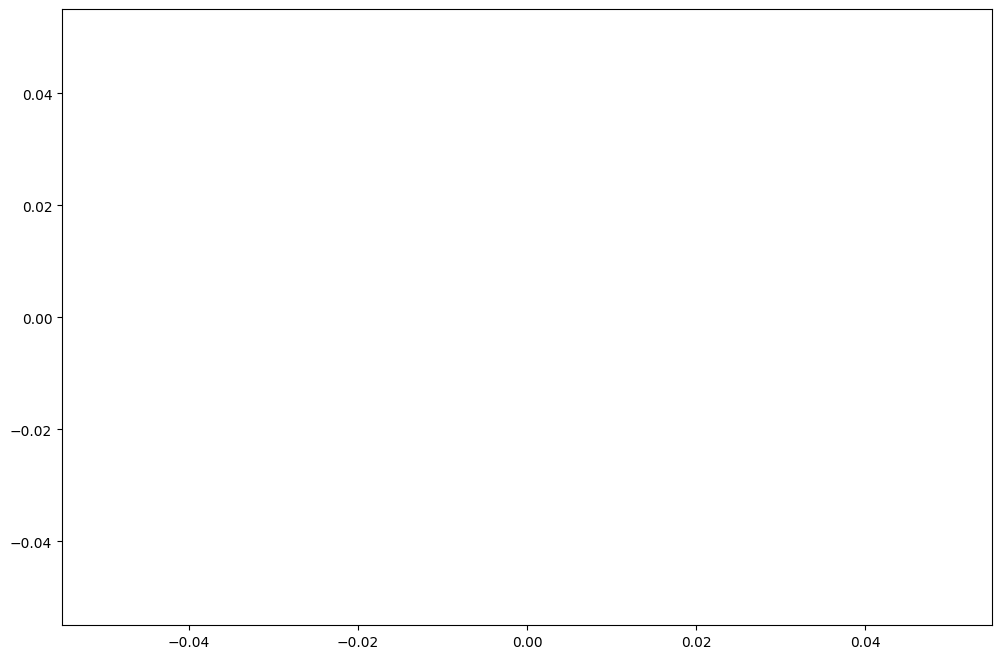

In [12]:
def visualize_xyz(x, y, z, t, time=False):         
    z_axis = t if time else z        

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(x, y, z_axis, color='blue', label='position', linewidth=1)
    ax.scatter(x[0], y[0], z_axis[0], color='red', s=10, label='starting point')

    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    zlabel = 'Frame number' if time else 'Z (m)'
    ax.set_zlabel(zlabel)
    ax.legend()
    
    plt.figure(figsize=(12, 8))
    plt.subplot(3, 1, 1)
    plt.plot(t, x)
    plt.title("X-axis Positions")
    plt.xlabel("frame number")
    plt.ylabel("X (m)")
    plt.grid()
    
    plt.subplot(3, 1, 2)
    plt.plot(t, y)
    plt.title("Y-axis Positions")
    plt.xlabel("frame number")
    plt.ylabel("Y (m)")
    plt.grid()
    
    plt.subplot(3, 1, 3)
    plt.plot(t, z)
    plt.title("Z-axis Positions")
    plt.xlabel("frame number")
    plt.ylabel("Z (m)")
    plt.grid()
    plt.show()
    
def visualize_xy(x, y, speed):
    plt.figure(figsize=(12, 8))
    plt.plot(x, y)
    plt.scatter([x[0], x[-1]], [y[0], y[-1]])
    x_diff, y_diff = x[-1]-x[0],y[-1]-y[0]
    plt.legend(['({:.2f}, {:.2f}) => {}'.format(x_diff, y_diff, np.sqrt((x_diff**2+y_diff**2)))] )
    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.xlim([0, 1.7])
    plt.ylim([0, 1.1])
    plt.title(f"Edmo's movement (speed: {speed} m/s) ")
    plt.grid()
visualize_xy(pose_datas.x, pose_datas.y, 500)
# visualize_xyz(pose_datas.x, pose_datas.y, pose_datas.z, pose_datas.t, False)

# <ins> IMU Data</ins>


folder: 0-179
./cleanData/Snake/0-179
14708
2e-05 0.998
2e-05 0.998
2e-05 0.998
Max amplitude frequency: 12.313026924122926
Max amplitude frequency: 12.190644547185205
Max amplitude frequency: 12.190644547185205


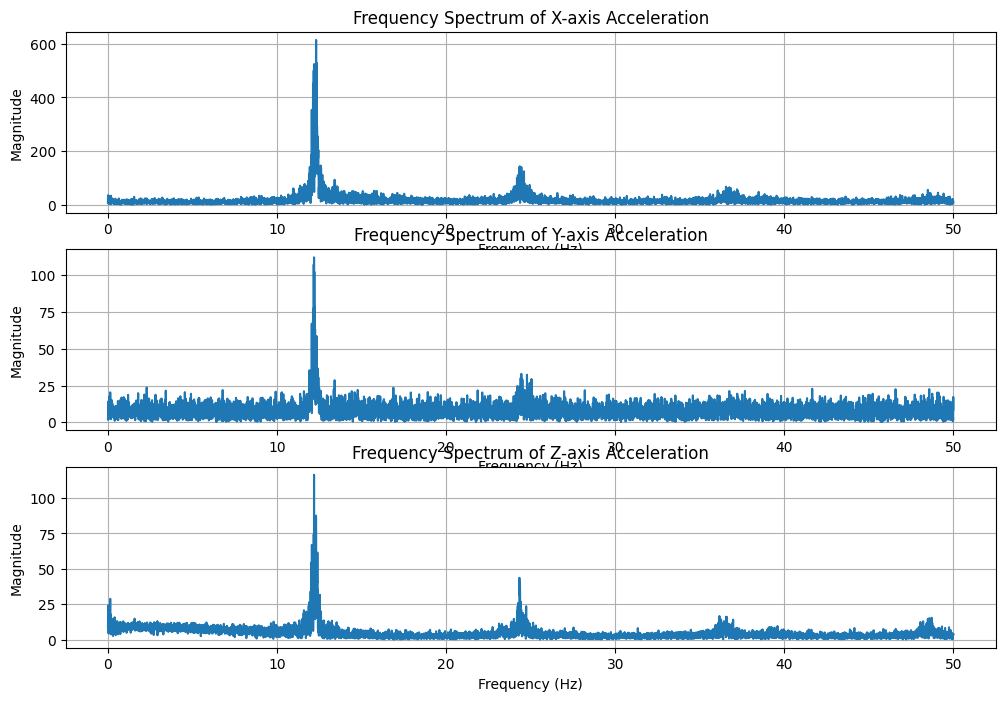

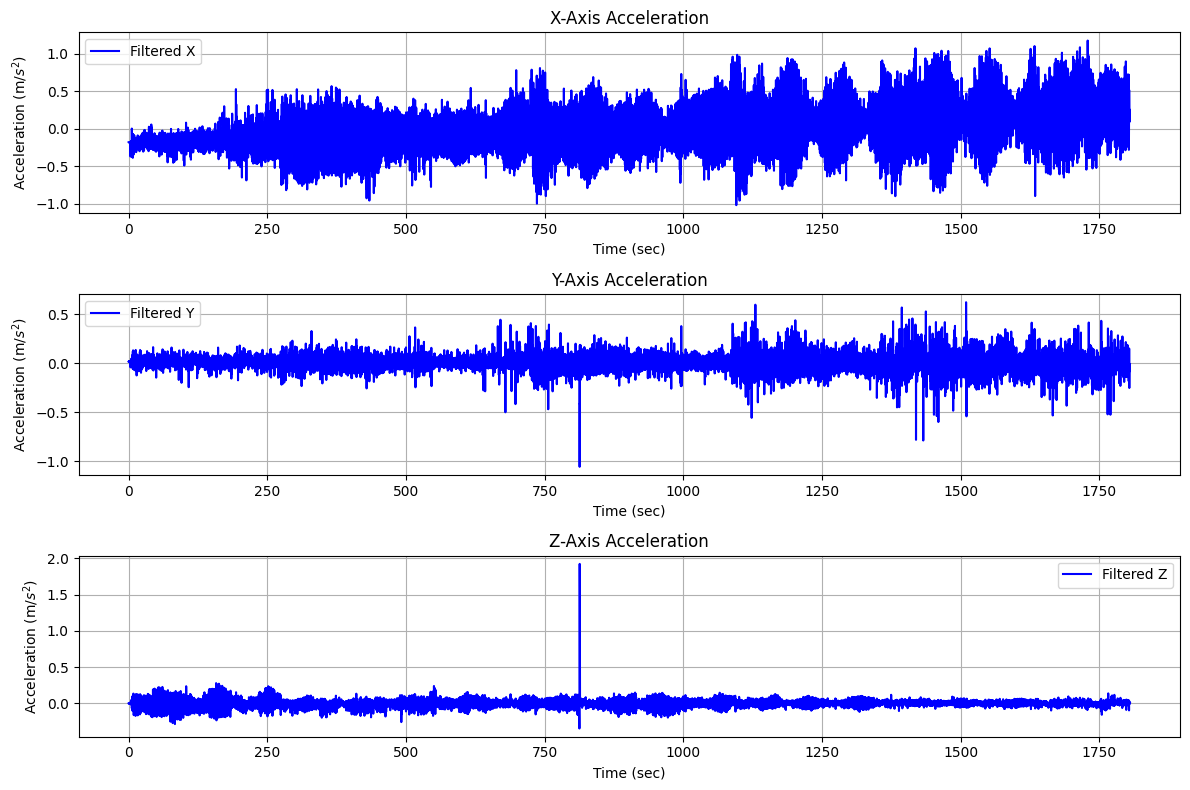

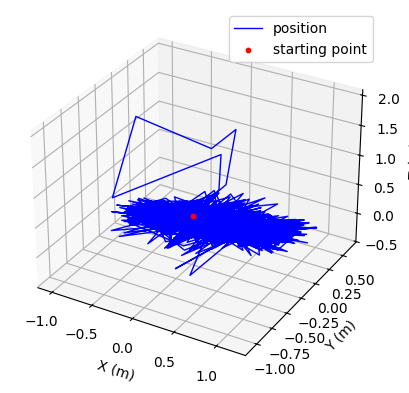

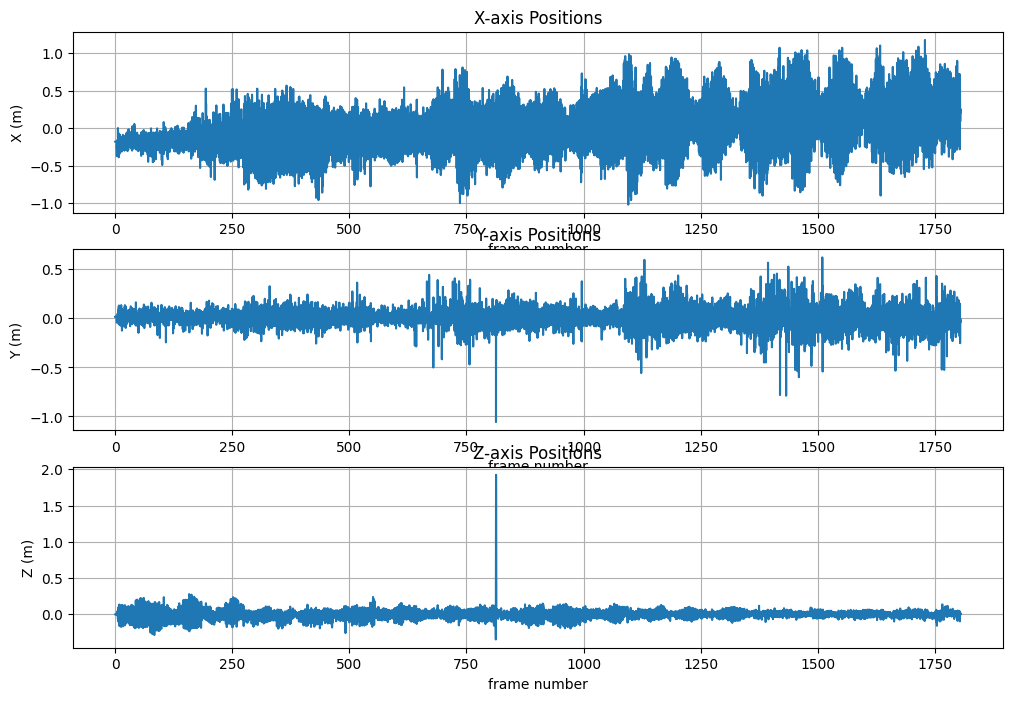

In [45]:
def load_IMU_data(file_path):
    data_dict = defaultdict(dict)

    # Regular expression to match the structure of each entry
    entry_pattern = re.compile(
        r"(?P<timestamp>\d+:\d+:\d+\.\d+)\s+"
        r"{Acceleration:\s+{Time:\s*(?P<acc_time>\d+),\s+Status:\s*(?P<acc_status>\d+),\s+Value:\s*\((?P<acc_values>[^)]+)\)},\s*"
        r"Gyroscope:\s+{Time:\s*(?P<gyro_time>\d+),\s+Status:\s*(?P<gyro_status>\d+),\s+Value:\s*\((?P<gyro_values>[^)]+)\)},\s*"
        r"Magnetic:\s+{Time:\s*(?P<mag_time>\d+),\s+Status:\s*(?P<mag_status>\d+),\s+Value:\s*\((?P<mag_values>[^)]+)\)},\s*"
        r"Gravity:\s+{Time:\s*(?P<grav_time>\d+),\s+Status:\s*(?P<grav_status>\d+),\s+Value:\s*\((?P<grav_values>[^)]+)\)},\s*"
        r"Rotation:\s+{Time:\s*(?P<rot_time>\d+),\s+Status:\s*(?P<rot_status>\d+),\s+Value:\s*\((?P<rot_values>[^)]+)\)}"
    )
    print(filepath)
    # Read the file line by line
    with open(file_path, 'r') as file:
        for line in file:
            match = entry_pattern.search(line)
            if match:
                timestamp = match.group("timestamp")
                # Organize sensor data into a nested dictionary
                data_dict[timestamp] = {
                    "Acceleration": {
                        "Time": int(match.group("acc_time")),
                        "Status": int(match.group("acc_status")),
                        "Value": tuple(map(float, match.group("acc_values").split(",")))
                    },
                    "Gyroscope": {
                        "Time": int(match.group("gyro_time")),
                        "Status": int(match.group("gyro_status")),
                        "Value": tuple(map(float, match.group("gyro_values").split(",")))
                    },
                    "Magnetic": {
                        "Time": int(match.group("mag_time")),
                        "Status": int(match.group("mag_status")),
                        "Value": tuple(map(float, match.group("mag_values").split(",")))
                    },
                    "Gravity": {
                        "Time": int(match.group("grav_time")),
                        "Status": int(match.group("grav_status")),
                        "Value": tuple(map(float, match.group("grav_values").split(",")))
                    },
                    "Rotation": {
                        "Time": int(match.group("rot_time")),
                        "Status": int(match.group("rot_status")),
                        "Value": tuple(map(float, match.group("rot_values").split(",")))
                    }
                }
    return data_dict

def low_pass_filter(data, low_cutoff, high_cutoff, fs, order=4):
    """
    Apply a low-pass Butterworth filter to the given data.

    Parameters:
        data (array-like): The input data to filter.
        cutoff (float): The cutoff frequency of the filter (Hz).
        fs (float): The sampling frequency (Hz).
        order (int): The order of the filter.

    Returns:
        filtered_data (ndarray): The filtered data.
    """
    low = low_cutoff / (0.5 * fs)
    high = high_cutoff /(0.5 * fs)
    print(low, high)
    b, a = butter(order, [low, high], btype='band', analog=False)
    # b, a = butter(order, low, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data, axis=0)
    return filtered_data

def compute_position(data_dict, cutoffs):
    # Initialize lists for time, acceleration, velocity, and position
    timestamps = []
    accelerations = []

    # Extract timestamps and acceleration values
    for timestamp, sensors in data_dict.items():
        acc = sensors["Acceleration"]["Value"]
        if len(timestamps) != 0 and timestamp < timestamps[-1]:
            print(f"Skipped timestamps {len(timestamps)}")
            timestamps = []
            accelerations = []
        timestamps.append(timestamp)
        accelerations.append(acc)

    # Convert timestamps to seconds since start
    start_time = timestamps[0]
    time_in_seconds = [
        sum(float(x) * t for x, t in zip(ts.split(":"), [3600, 60, 1]))
        - sum(float(x) * t for x, t in zip(start_time.split(":"), [3600, 60, 1]))
        for ts in timestamps
    ]

    # Convert acceleration list to numpy array
    accelerations = np.array(accelerations)
    time_in_seconds = np.array(time_in_seconds)

    # Apply low-pass filter
    # sampling_frequency = 1 / np.mean(np.diff(time_in_seconds))  # Hz
    # print(sampling_frequency)
    sampling_frequency = 100

    filtered_accs = []
    for i, cutoff in enumerate(cutoffs):
        filtered_accs.append(low_pass_filter(accelerations[:, i], cutoff[0], cutoff[1], sampling_frequency))
    filtered_accelerations = np.column_stack(filtered_accs)

    # Integrate acceleration to find velocity (v = ∫a dt)
    velocities = integrate.cumulative_trapezoid(filtered_accelerations, time_in_seconds, axis=0, initial=0)

    # Integrate velocity to find position (s = ∫v dt)
    positions = integrate.cumulative_trapezoid(velocities, time_in_seconds, axis=0, initial=0)

    plot_fft = True
    if plot_fft:
        n = len(accelerations[:,0])  # Number of samples

        freqs = np.fft.rfftfreq(n, d=1/sampling_frequency)  # Frequency bins
        fft_magnitude_x = np.abs(np.fft.rfft(accelerations[:,0]))  
        fft_magnitude_y = np.abs(np.fft.rfft(accelerations[:,1]))  
        fft_magnitude_z = np.abs(np.fft.rfft(accelerations[:,2]))  
        print(f'Max amplitude frequency: {freqs[np.argmax(fft_magnitude_x)]}')
        print(f'Max amplitude frequency: {freqs[np.argmax(fft_magnitude_y)]}')
        print(f'Max amplitude frequency: {freqs[np.argmax(fft_magnitude_z)]}')

        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        plt.plot(freqs, fft_magnitude_x)
        plt.title("Frequency Spectrum of X-axis Acceleration")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.grid()
        
        plt.subplot(3, 1, 2)
        plt.plot(freqs, fft_magnitude_y)
        plt.title("Frequency Spectrum of Y-axis Acceleration")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.grid()
        
        plt.subplot(3, 1, 3)
        plt.plot(freqs, fft_magnitude_z)
        plt.title("Frequency Spectrum of Z-axis Acceleration")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.grid()
        plt.show()

    # Plotting the filtered acceleration data
    plot_filtered = True
    if plot_filtered:
        plt.figure(figsize=(12, 8))

        # X-axis
        plt.subplot(3, 1, 1)
        # plt.plot(time_in_seconds, acc_x, label="Original X", color="red", alpha=0.6)
        plt.plot(time_in_seconds, filtered_accs[0], label="Filtered X", color="blue")
        plt.title("X-Axis Acceleration")
        plt.ylabel("Acceleration (m/$s^2$)")
        plt.xlabel("Time (sec)")
        plt.legend()
        plt.grid()

        # Y-axis
        plt.subplot(3, 1, 2)
        # plt.plot(time_in_seconds, acc_y, label="Original Y", color="green", alpha=0.6)
        plt.plot(time_in_seconds, filtered_accs[1], label="Filtered Y", color="blue")
        plt.title("Y-Axis Acceleration")
        plt.ylabel("Acceleration (m/$s^2$)")
        plt.xlabel("Time (sec)")
        plt.legend()
        plt.grid()

        # Z-axis
        plt.subplot(3, 1, 3)
        # plt.plot(time_in_seconds, acc_z, label="Original Z", color="purple", alpha=0.6)
        plt.plot(time_in_seconds, filtered_accs[2], label="Filtered Z", color="blue")
        plt.title("Z-Axis Acceleration")
        plt.ylabel("Acceleration (m/$s^2$)")
        plt.xlabel("Time (sec)")
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()
        visualize_xyz(filtered_accs[0],filtered_accs[1],filtered_accs[2],time_in_seconds,False)
    return positions



dir = './cleanData/Snake'
# dir = './cleanData/2024.09.17/Kumoko'
for folder in os.listdir(dir):
    # if folder != '15.50.58':
    #     continue
    if folder == '1080-1259':
        break
    if os.path.splitext(folder)[1] != '':
        continue
    print(f'folder: {folder}')
    filepath = f'{dir}/{folder}'
    IMU_data = None
    for file in os.listdir(filepath):
        if file == "IMU.log":
            IMU_data = load_IMU_data(f'{filepath}/{file}')
            break
    print(len(IMU_data))
    positions = compute_position(IMU_data, ((0.001,50-0.1),)*3) 

    # Output positions
    """for i, pos in enumerate(positions):
        print(f"Position at t={i}: {pos}")
    
    prev_time = None
    for timestamp in IMU_data.keys():
        if prev_time is None:
            prev_time = timestamp
            continue
        print(IMU_data[timestamp])
        print(IMU_data[timestamp]['Gravity'])
        break
 """       
                    


clean path: ./cleanData/2025.01.07/Snake1/12.50.59
Row deleted for IMU log: 2, final size: 817
Row deleted for index 0: 1, final size: 817
Row deleted for index 1: 1, final size: 817
Row deleted for index 2: 2, final size: 817
Row deleted for index 3: 2, final size: 817
--- 1771.1064932346344 seconds ---
IMU.log
./cleanData/Snake/plot data.log
817
2e-05 0.998
2e-05 0.998
2e-05 0.998
Max amplitude frequency: 0.12239902080783353
Max amplitude frequency: 25.58139534883721
Max amplitude frequency: 0.24479804161566707


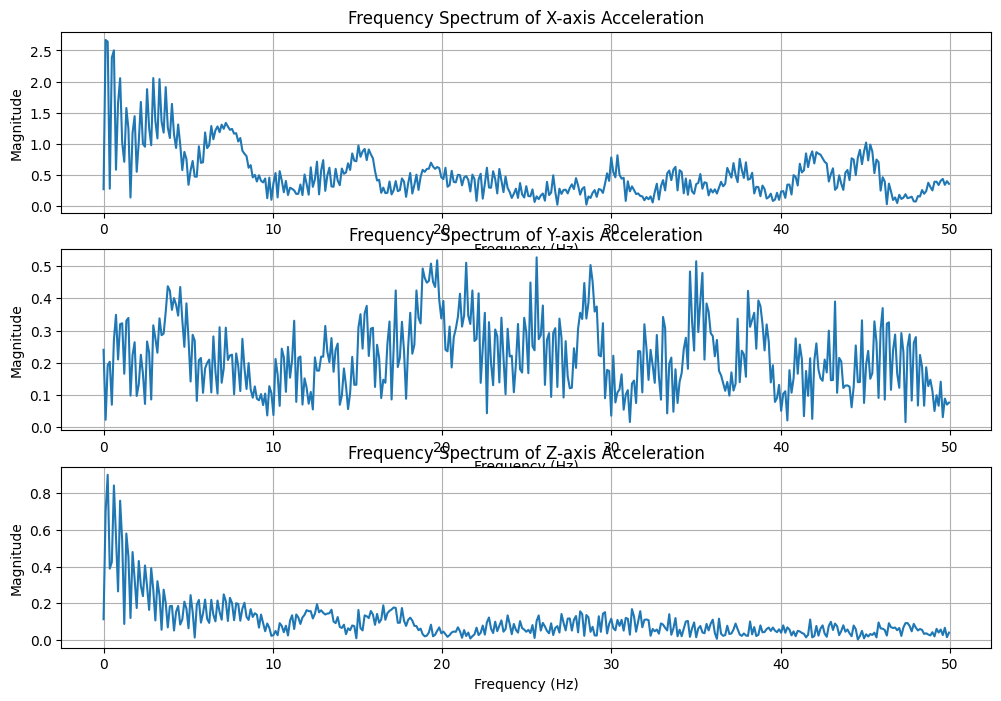

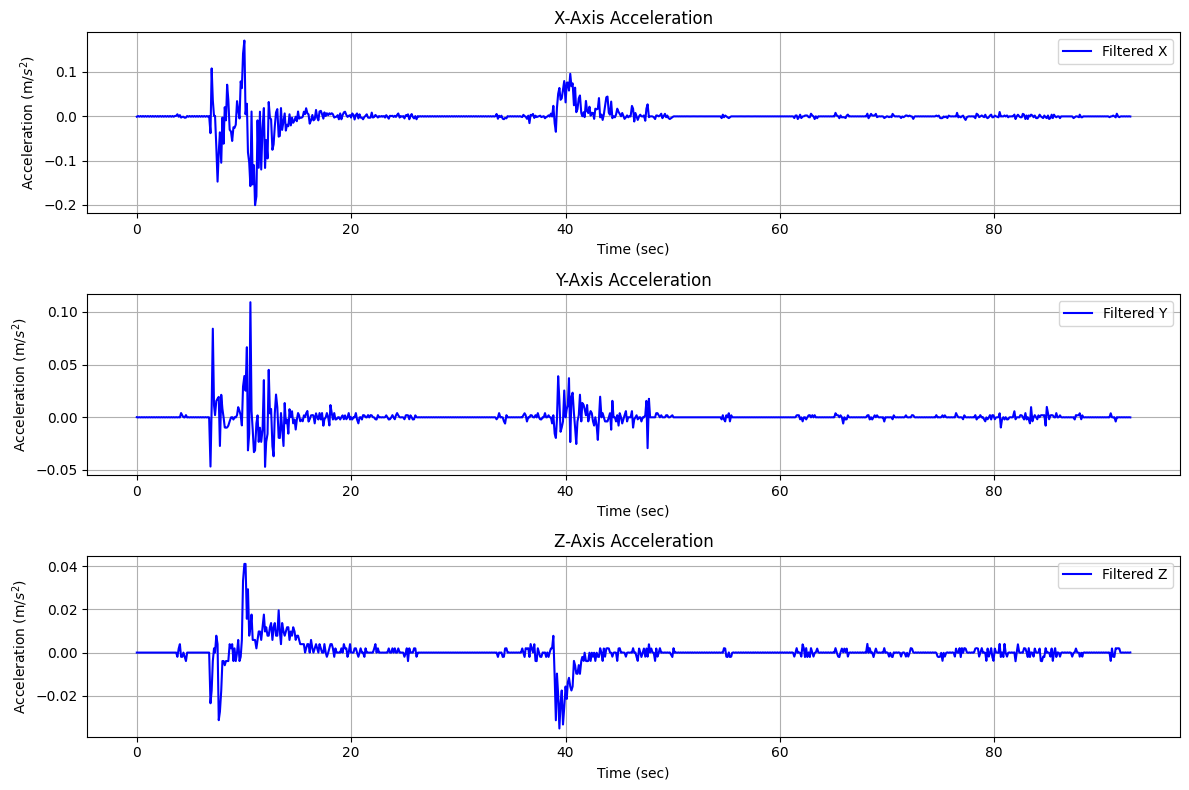

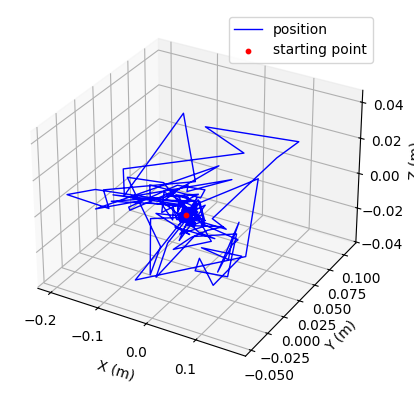

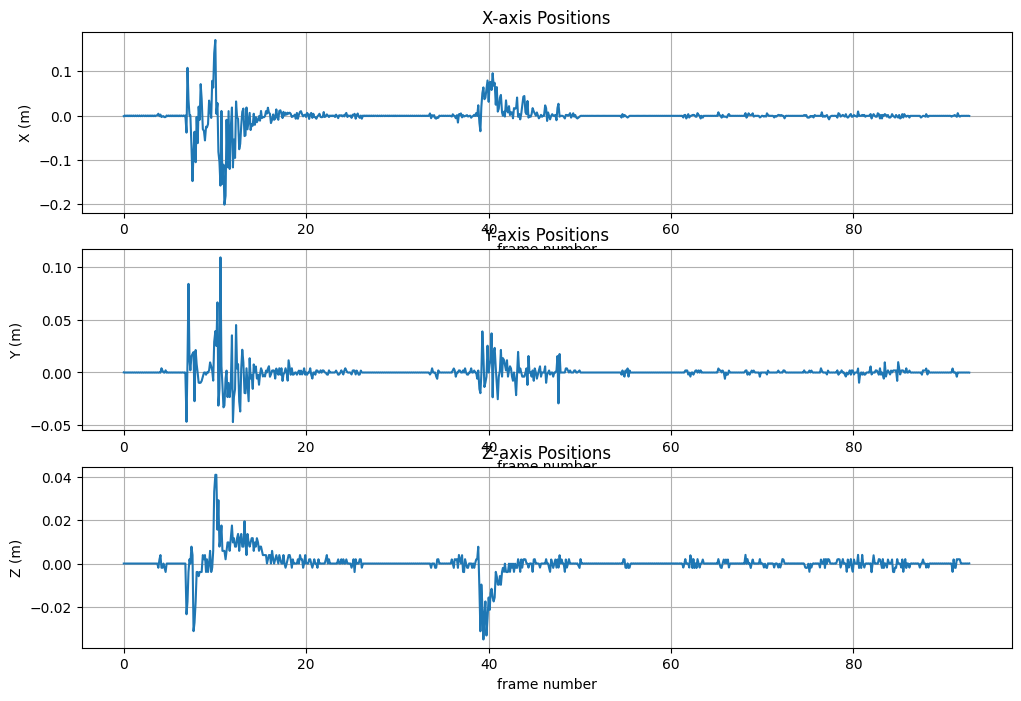

In [44]:
path = './SessionLogs/2025.01.07/Snake1/12.50.59'
clean(path, False)
path = './cleanData/2025.01.07/Snake1/12.50.59'
for file in os.listdir(path):
    print(file)
    if file == "IMU.log":
        IMU_data = load_IMU_data(f'{path}/{file}')
        
    print(len(IMU_data))
    # for low in range(20, 100, 1):
    #     low = low/10
    #     if not low:
    #         continue
    #     positions = compute_position(IMU_data, ((low,low+0.1),)*3) 
    positions = compute_position(IMU_data, ((0.001,50-0.1),)*3) 
    break



# Learning plots


In [3]:

param_ranges = {
    'freq': [1, 1],
    'amp': [0, 90],
    'off': [0, 180],
    'phb': [0, 180]
}
def decode_unique_key(bitwise_key, param_ranges, nb_legs):
    ordered_params = ["amp", "off", "phb"]  # Define the order of parameters explicitly
    params_to_decode = {}

    for param in ordered_params:
        for i in range(1, nb_legs + 1):
            if param in param_ranges:
                params_to_decode[f"{param}{i}"] = tuple(param_ranges[param])

    decoded_values = []
    total_bits = 0

    for param in params_to_decode:
        min_val, max_val = params_to_decode[param]
        range_size = max_val - min_val + 1
        bits = math.ceil(math.log2(range_size))

        # Extract the value for this parameter
        mask = (1 << bits) - 1
        encoded_value = (bitwise_key >> total_bits) & mask

        # Decode the value
        decoded_value = encoded_value + min_val
        decoded_values.append(decoded_value)

        # Move to the next parameter
        total_bits += bits

    return decoded_values

learning_data = []

path = './SessionLogs/'
for folder in os.listdir(path):  # Read folders of folders
    # print(folder)
    for edmo_folder in os.listdir(f'{path}/{folder}'):
        # print(edmo_folder)
        newPath = f'{path}/{folder}/{edmo_folder}/'
        for time_folder in os.listdir(newPath):
            location = newPath + time_folder
            for file in os.listdir(location):
                if file == 'param_history.log':
                    param_path = f"{location}/{file}"
                    learning_data.append(json.load(open(param_path, 'r')))
print(f"data from {len(learning_data)} learning sessions")

# learning clean up
top_learning = set()
for data_index, data in enumerate(learning_data):
    for iteration in data:
        if not isinstance(iteration[1], dict):
            continue
        for points, speed in iteration[0]:
            hashable_obj = (tuple(points), speed)
            top_learning.add(hashable_obj)

# background clean up
background_data = []
for key, values in json.load(open('./Utilities/parameters_dictionnary_2.log', 'r')).items():
    speed, confidence = values    
    param = decode_unique_key(int(key), param_ranges, 2)
    background_data.append((param, values[0]))
    
# Get top parameters
top_3_background_data = sorted(background_data, key=lambda x: x[1], reverse=True)[:3]
top_3_learning_data = sorted(top_learning, key=lambda x: x[1], reverse=True)[:5]

# Print the top 3 entries
for idx, entry in enumerate(top_3_background_data, start=1):
    print(f"Top {idx}: {entry}")
for idx, entry in enumerate(top_3_learning_data, start=1):
    print(f"Top {idx}: {entry}")

data from 13 learning sessions
Top 1: ([90, 90, 0, 180, 64, 12], 0.04225769274242996)
Top 2: ([55, 90, 0, 180, 64, 12], 0.02899272079823121)
Top 3: ([90, 90, 103, 78, 0, 126], 0.023890507566054604)
Top 1: ((90, 90, 0, 180, 64, 12), 0.04225769274242996)
Top 2: ((90, 58, 98, 100, 359, 62), 0.039866116498910815)
Top 3: ((90, 90, 73, 93, 113, 174), 0.03527106322744506)
Top 4: ((90, 90, 73, 92, 113, 174), 0.03527106322744506)
Top 5: ((90, 58, 108, 100, 359, 62), 0.027262984810244653)


### Scatter plot for learning data

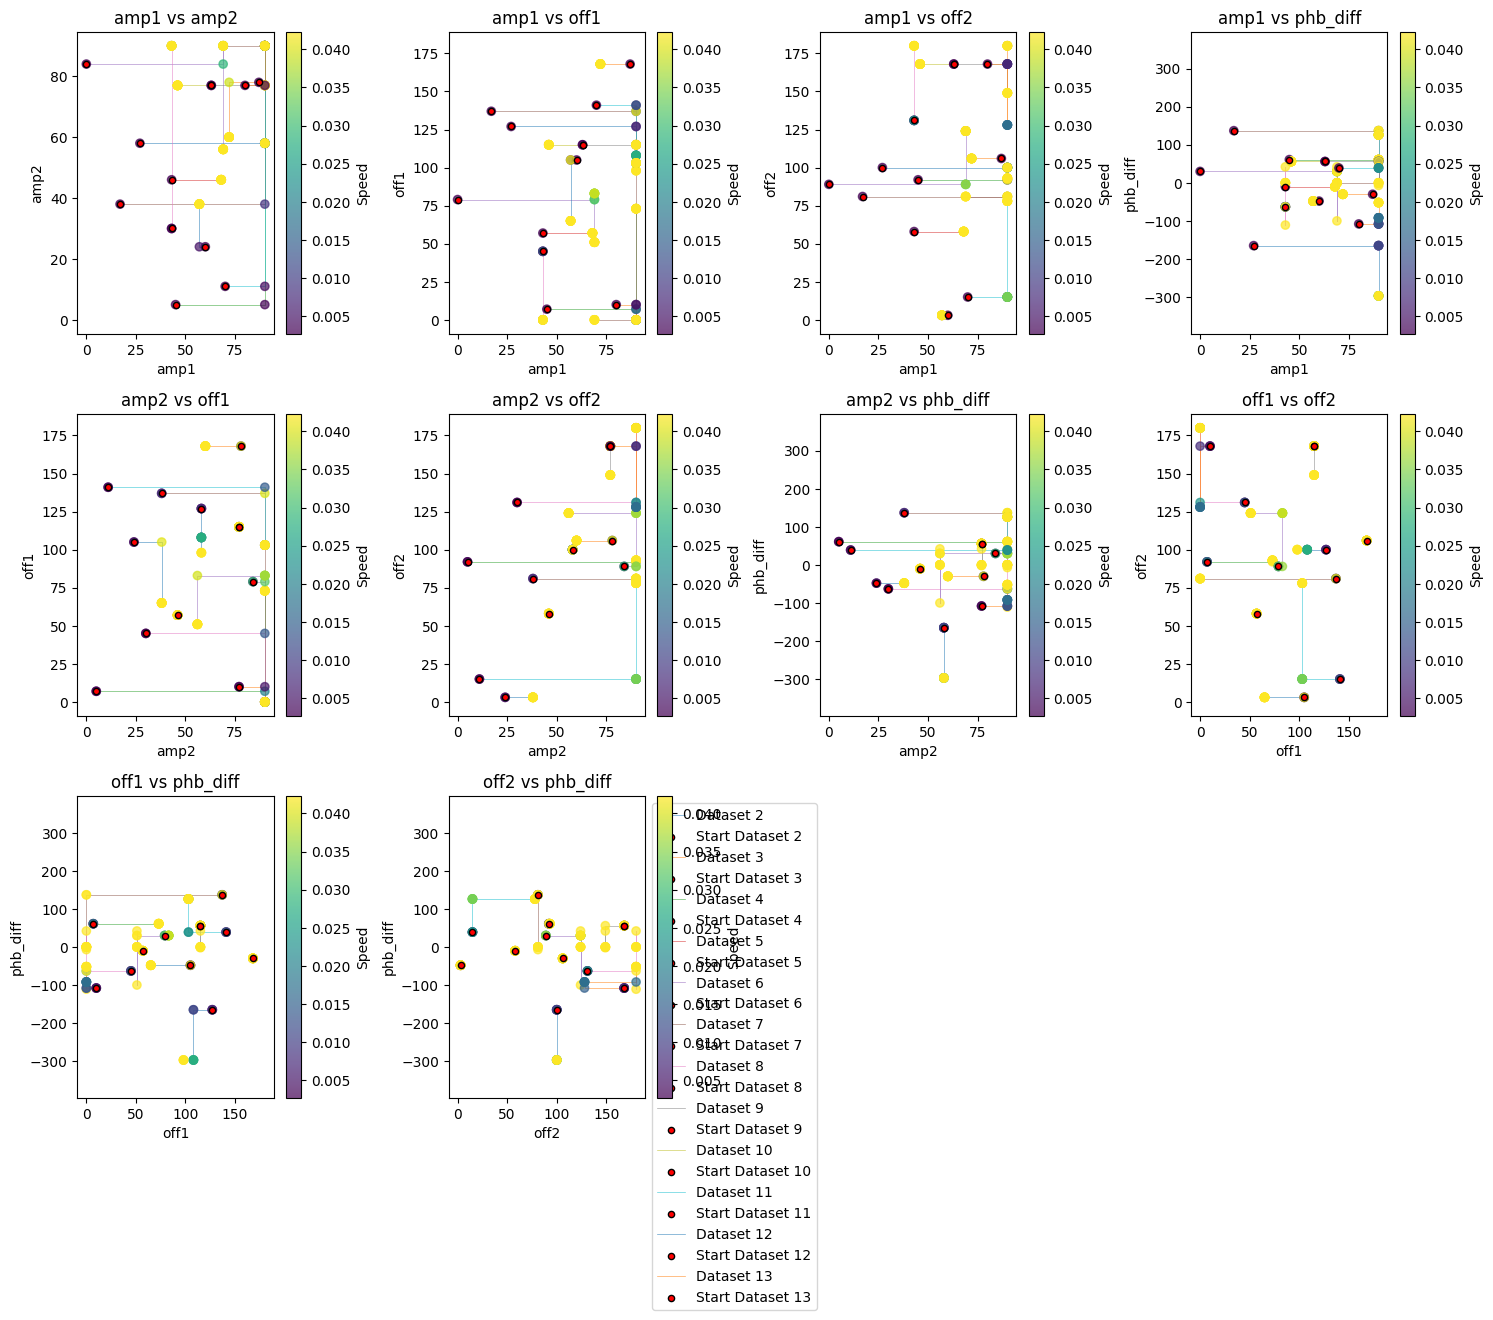

In [74]:
def compute_all_learning_2d_plot(learning_data):
    # Parameter labels and ranges
    parameter_labels = ["amp1", "amp2", "off1", "off2", "phb_diff"]
    parameter_ranges = {
        "amp1": (0, 90),
        "amp2": (0, 90),
        "off1": (0, 180),
        "off2": (0, 180),
        "phb_diff": (-360, 360),  # The range for phb_diff
    }
    margin = 0.05  # 5% margin
    parameter_ranges_with_margin = {
        key: (
            val[0] - (val[1] - val[0]) * margin,
            val[1] + (val[1] - val[0]) * margin,
        )
        for key, val in parameter_ranges.items()
    }

    # Prepare the figure
    num_params = len(parameter_labels)
    plt.figure(figsize=(15, 15))
    plot_idx = 1

    # Iterate over all parameter pairs
    for i in range(num_params):
        for j in range(i + 1, num_params):
            plt.subplot(num_params - 1, num_params - 1, plot_idx)

            # For each parameter pair, plot lines for all datasets
            for data_index, data in enumerate(learning_data):
                x_vals, speeds = [], []

                for iteration in data:
                    if not isinstance(iteration[1], dict):
                        continue
                    for points, speed in iteration[0]:
                        x_vals.append(points)
                        speeds.append(speed)
                if len(x_vals) <= 0:
                    continue
                
                # Extract x and y for this parameter pair
                x = [params[i] for params in x_vals]
                y = [params[j] for params in x_vals]

                # Create a new list for phb_diff (phb2 - phb1)
                if i == 4:  # phb1 is the 4th parameter (index 4)
                    phb_diff = [params[5] - params[4] for params in x_vals]  # phb2 - phb1
                    x = phb_diff  # Replace x with phb_diff for the pair
                if j == 4:  # phb1 is the 4th parameter (index 4)
                    phb_diff = [params[5] - params[4] for params in x_vals]  # phb2 - phb1
                    y = phb_diff  # Replace y with phb_diff for the pair

                # Plot the continuous line
                plt.plot(
                    x, y, linestyle="-", linewidth=0.5, alpha=0.7,
                    label=f"Dataset {data_index + 1}",
                    zorder=1
                )

                # Scatter plot with color-coded speeds
                scatter = plt.scatter(
                    x, y, c=speeds, cmap="viridis", zorder=2, alpha=0.7
                )

                # Highlight the starting point for this dataset
                plt.scatter(
                    x[0], y[0], color="red", edgecolor="black", s=20,
                    zorder=3, label=f"Start Dataset {data_index + 1}"
                )

            plt.xlabel(parameter_labels[i])
            plt.ylabel(parameter_labels[j])
            plt.title(f"{parameter_labels[i]} vs {parameter_labels[j]}")

            # Set axis limits with margins
            plt.xlim(parameter_ranges_with_margin[parameter_labels[i]])
            plt.ylim(parameter_ranges_with_margin[parameter_labels[j]])

            # Add colorbar
            plt.colorbar(scatter, label="Speed")

            plot_idx += 1

    # Adjust layout and add a legend
    plt.tight_layout()
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

# paths = ['./param_history.log', './param_history1.log']  # Multiple data files
# learning_data = [json.load(open(path, 'r')) for path in paths]

compute_all_learning_2d_plot(learning_data)


### Heatmap for learning data

C:\Users\me\AppData\Local\Temp\ipykernel_50272\3375553358.py:111: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper left", bbox_to_anchor=(1, 1))


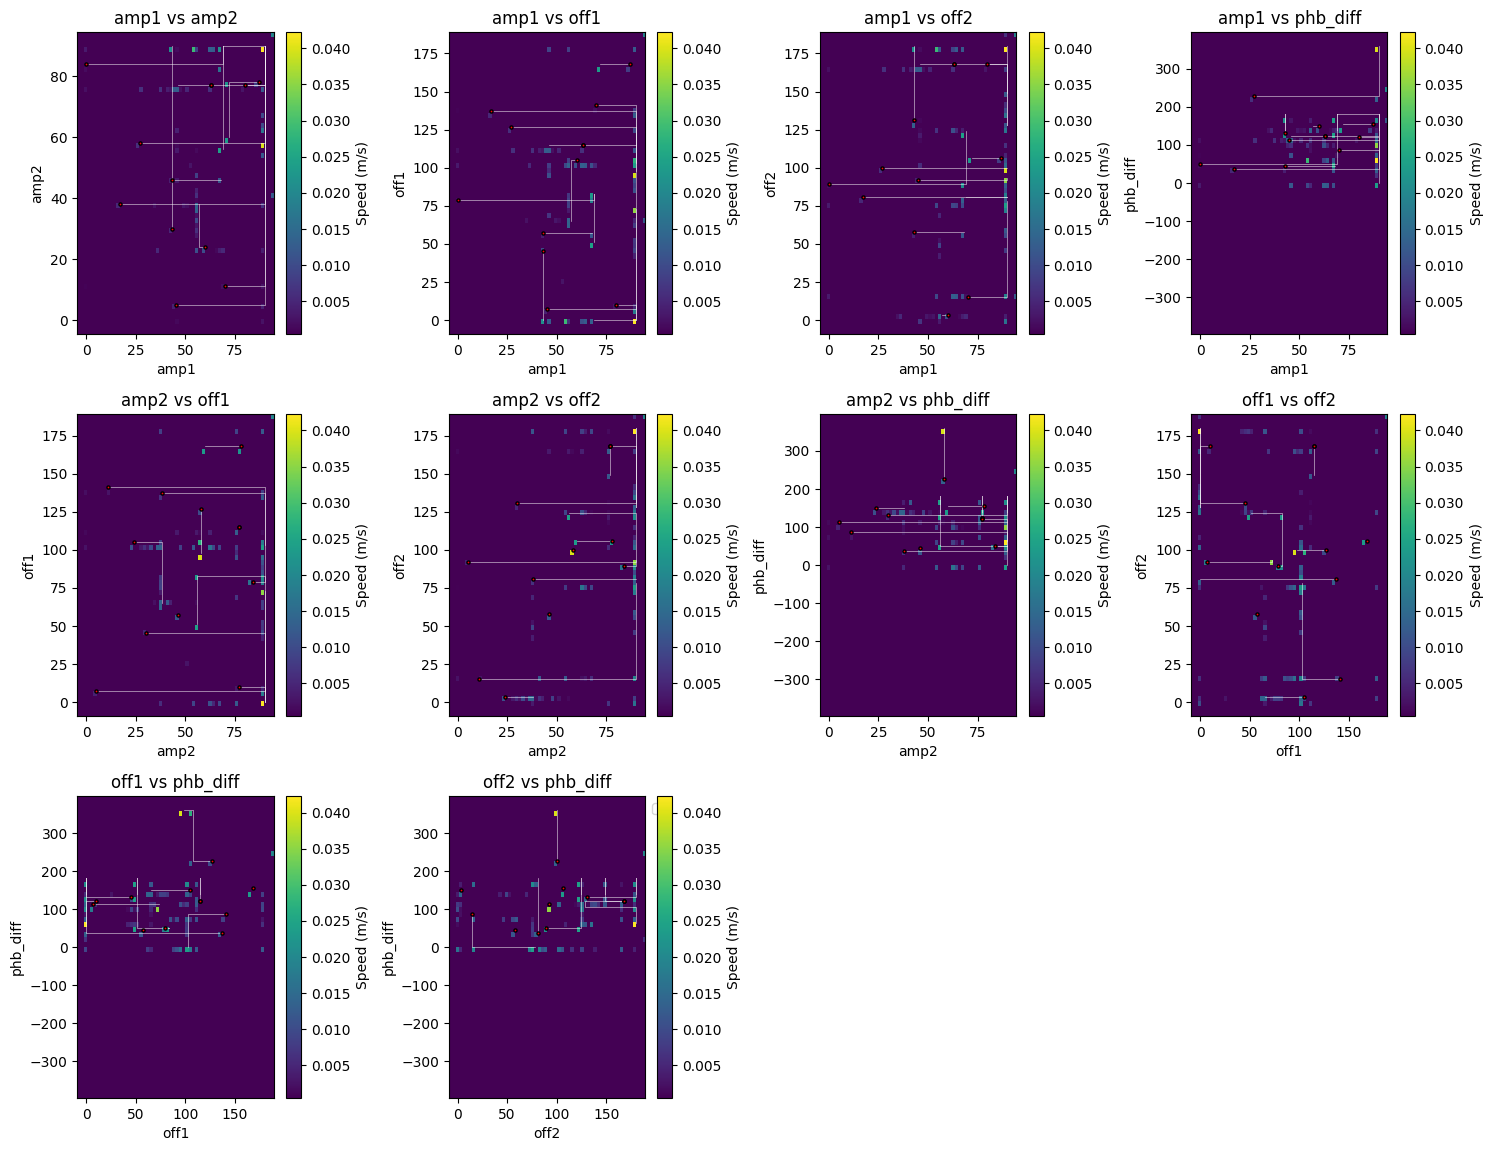

In [4]:
def compute_all_learning_2d_heatmap(learning_data, background_data, resolution=60):
    # Parameter labels and ranges (update phb1, phb2 to phb_diff)
    parameter_labels = ["amp1", "amp2", "off1", "off2", "phb_diff"]
    parameter_ranges = {
        "amp1": (0, 90),
        "amp2": (0, 90),
        "off1": (0, 180),
        "off2": (0, 180),
        "phb_diff": (-360, 360),  # Range of phb_diff (phb2 - phb1)
    }
    margin = 0.05  # 5% margin
    parameter_ranges_with_margin = {
        key: (
            val[0] - (val[1] - val[0]) * margin,
            val[1] + (val[1] - val[0]) * margin,
        )
        for key, val in parameter_ranges.items()
    }

    num_params = len(parameter_labels)
    plt.figure(figsize=(15, 15))
    plot_idx = 1

    all_speeds = []  # Collect all speeds to determine color scale range

    for i in range(num_params):
        for j in range(i + 1, num_params):
            plt.subplot(num_params - 1, num_params - 1, plot_idx)
            plt.gca().set_facecolor("black")  # Set the subplot background to black

            # Create a grid for the heatmap
            x_range = parameter_ranges_with_margin[parameter_labels[i]]
            y_range = parameter_ranges_with_margin[parameter_labels[j]]
            x_bins = np.linspace(x_range[0], x_range[1], resolution)
            y_bins = np.linspace(y_range[0], y_range[1], resolution)
            heatmap = np.full((resolution, resolution), np.nan)  # Initialize with NaN

            # Process background data
            for params, speed in background_data:
                # Adjust to use phb_diff instead of phb1, phb2
                phb_diff = params[5] - params[4]  # phb2 - phb1

                x_val, y_val = params[i], params[j]
                xi = np.digitize([x_val], x_bins)[0] - 1
                yi = np.digitize([y_val], y_bins)[0] - 1

                if 0 <= xi < resolution and 0 <= yi < resolution:
                    if np.isnan(heatmap[yi, xi]) or heatmap[yi, xi] < speed:
                        heatmap[yi, xi] = speed
                    all_speeds.append(speed)

            # Process learning data (learning_data) on top of background
            if learning_data is not None:
                for data_index, data in enumerate(learning_data):
                    x_vals, y_vals, speeds = [], [], []

                    for iteration in data:
                        if not isinstance(iteration[1], dict):
                            continue
                        for points, speed in iteration[0]:
                            # Adjust to use phb_diff instead of phb1, phb2
                            phb_diff = points[4] - points[5]  # phb2 - phb1
                            x_vals.append(points[i])
                            y_vals.append(points[j])
                            speeds.append(speed)
                            all_speeds.append(speed)

                    if len(x_vals) > 0:
                        x_indices = np.digitize(x_vals, x_bins) - 1
                        y_indices = np.digitize(y_vals, y_bins) - 1

                        for xi, yi, speed in zip(x_indices, y_indices, speeds):
                            if 0 <= xi < resolution and 0 <= yi < resolution:
                                if np.isnan(heatmap[yi, xi]) or heatmap[yi, xi] < speed:
                                    heatmap[yi, xi] = speed

                        # Overlay white lines for learning data
                        plt.plot(
                            x_vals, y_vals, linestyle="-", linewidth=0.5, color="white", alpha=0.7,
                            zorder=1, label=f"Dataset {data_index + 1}" if data_index == 0 else ""
                        )
                        # Add "X" mark at the starting point
                        plt.scatter(
                            x_vals[0], y_vals[0], color="red", edgecolor="black", s=5, marker="o", zorder=3,
                            label=f"Start Dataset {data_index + 1}" if data_index == 0 else ""
                        )

            # Determine color scale from speed values
            if all_speeds:
                vmin, vmax = min(all_speeds), max(all_speeds)
            else:
                vmin, vmax = 0, 1  # Default if no speeds are available

            # Replace NaN with a very low value (black in heatmap)
            heatmap[np.isnan(heatmap)] = vmin - 1

            # Plot heatmap (integrate both background and learning data)
            plt.imshow(
                heatmap, origin="lower", extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]),
                cmap="viridis", aspect="auto", interpolation="nearest", vmin=vmin, vmax=vmax
            )
            plt.colorbar(label="Speed (m/s)")

            plt.xlabel(parameter_labels[i])
            plt.ylabel(parameter_labels[j])
            plt.title(f"{parameter_labels[i]} vs {parameter_labels[j]}")

            plot_idx += 1

    plt.tight_layout()
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

compute_all_learning_2d_heatmap(learning_data, background_data=background_data)

2924
[{'Amp_motor_1': 20, 'Amp_motor_2': 20, 'Offset_motor_1': 0, 'Offset_motor_2': 0, 'Phase_difference': 0.0, 'x speed': -0.05273692650612445, 'y speed': -0.0040497736480007915, 'z speed': 0.011682145159954041, 'xyz speed': 0.05416693271222445, 'xy speed': 0.052892193033683275, 'x frame speed': -0.0001328386058088777, 'y frame speed': -1.0200941178843304e-05, 'z frame speed': 2.942605833741572e-05, 'xyz frame speed': 0.00013644063655472152, 'xy frame speed': 0.00013322970537451705, 'exp nb': 0, 'nb frames': 397}, {'Amp_motor_1': 20, 'Amp_motor_2': 20, 'Offset_motor_1': 0, 'Offset_motor_2': 0, 'Phase_difference': 40.0, 'x speed': -0.0006886271926663332, 'y speed': 0.010256565929499528, 'z speed': 0.032820922239008773, 'xyz speed': 0.034393084896468806, 'xy speed': 0.010279657196456021, 'x frame speed': -3.1444164048691017e-06, 'y frame speed': 4.683363438127638e-05, 'z frame speed': 0.0001498672248356565, 'xyz frame speed': 0.00015704604975556532, 'xy frame speed': 4.693907395642018e-

C:\Users\Ye\AppData\Local\Temp\ipykernel_9188\3543946483.py:111: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



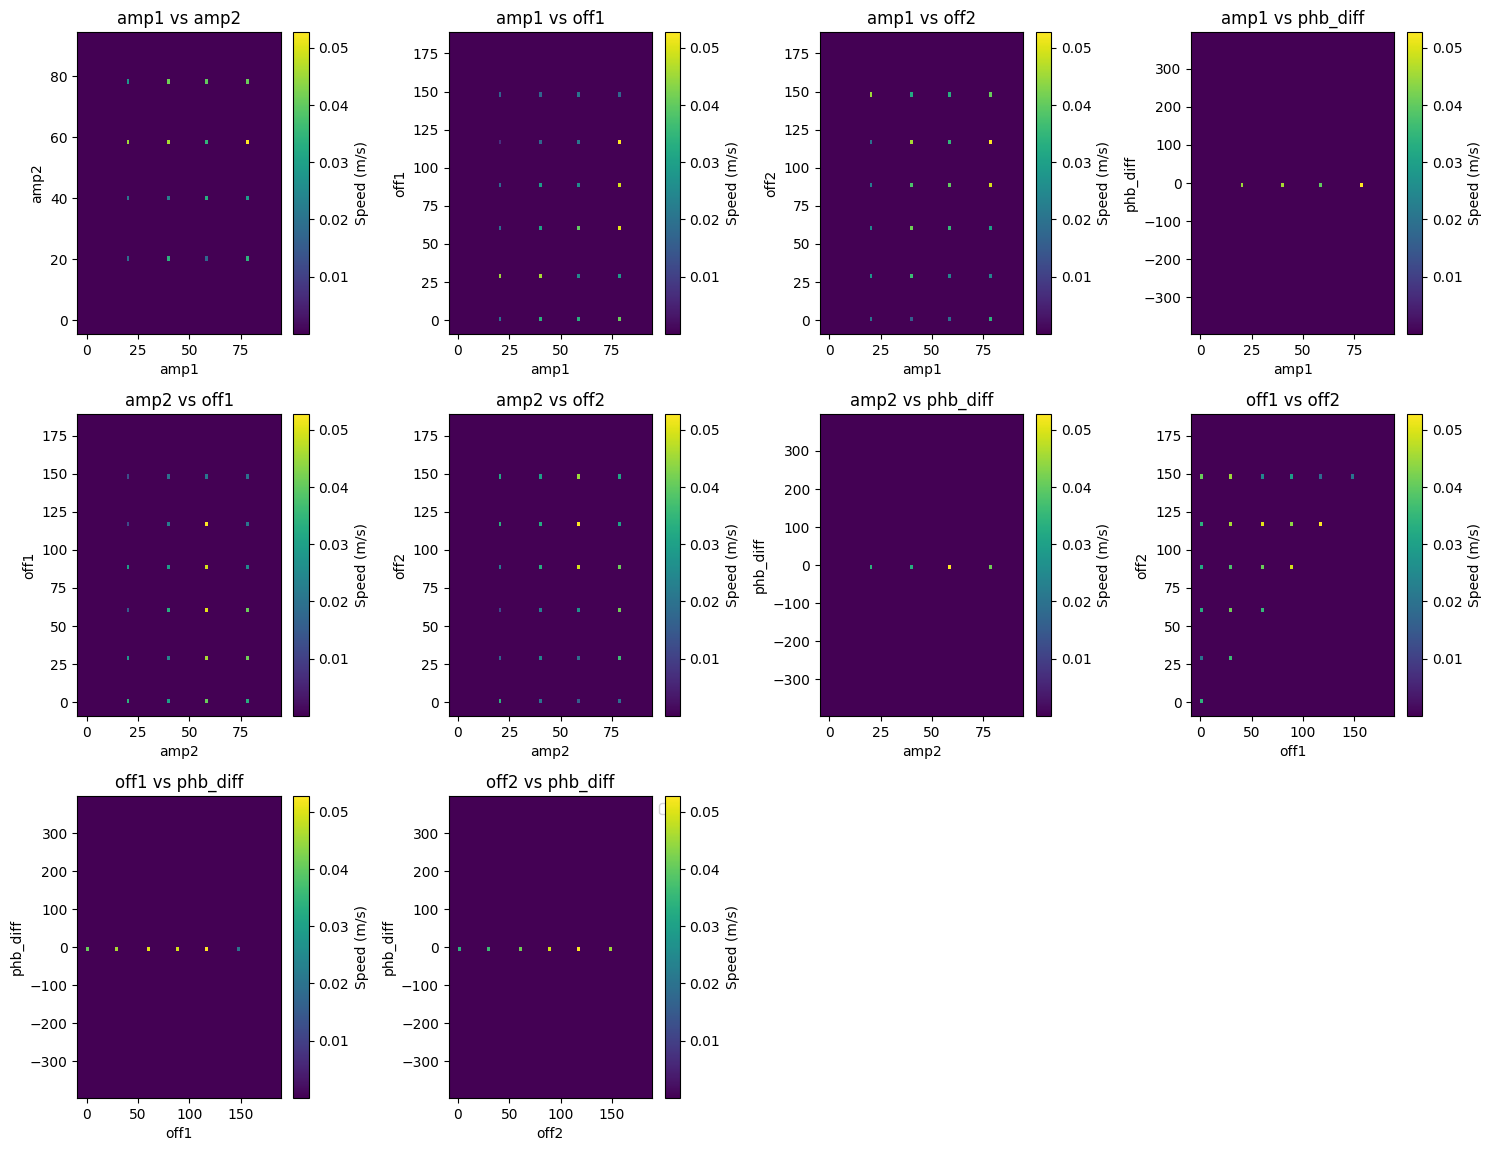

In [73]:
# Retrieve the data from the json file
with open('cleanData/Snake/plot data.log', 'r') as f:
    data = json.load(f)

# Convert to DataFrame
plot_data = pd.DataFrame.from_records(data)
plot_data = plot_data.to_dict(orient='records')
print(len(plot_data))
print(plot_data)
print(type(plot_data))
plot_speed = []
systematic_background_data = []
for values in plot_data:
    amp1 = values['Amp_motor_1']
    amp2 = values['Amp_motor_2']
    off1 = values['Offset_motor_1']
    off2 = values['Offset_motor_2']
    phb1 = 0.0
    phb2 = values['Phase_difference']
    speed = values['xy frame speed']
    systematic_background_data.append(([amp1, amp2, off1, off2, phb1, phb2], speed*30))
    plot_speed.append(values['xy frame speed'])    
print(max(plot_speed)*30)
print(systematic_background_data)
compute_all_learning_2d_heatmap(None, systematic_background_data)
 